In [1]:
import os
from numpy.lib.shape_base import split
from sklearn import metrics
from sklearn import preprocessing, model_selection
import glob
import torch
import pandas as pd
import numpy as np
import os

import config
import dataset

In [52]:
def split(x):
    return [i for i in str(x)]

def frst_char(x):
    x = x.split("/")[3].split(".")[0]
    return int(x)

In [9]:
# image_files
image_files = glob.glob("../input/archive/*.jpg")
print(image_files[:4])
# targets
targets_orig = [i.split("/")[-1][:-4] for i in image_files]
print(targets_orig[:5])
# creating a list of list for the targets
targets = [[j for j in i] for i in targets_orig]
# flattening the lists
targets_flat = [item for sublists in targets for item in sublists]
# print(targets_flat)
lbl_encoder = preprocessing.LabelEncoder()
lbl_encoder.fit(targets_flat)
enc_targets = [lbl_encoder.transform(x) for x in targets]
# this +1 is to add 1 to all the encoded labels, so that we could use 0 for the unknown values
enc_targets = np.array(enc_targets) + 1
print(len(enc_targets))
print(len(lbl_encoder.classes_))
(
    train_imgs,
    test_imgs,
    train_targets_orig,
    test_target_orig,
    train_targets,
    test_targets,
) = model_selection.train_test_split(
    image_files, targets_orig, enc_targets, test_size=0.1, random_state=42
)
train_dataset = dataset.ClassificationDataset(
    image_paths=train_imgs,
    targets=train_targets,
    resize=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    shuffle=True,
)
test_dataset = dataset.ClassificationDataset(
    image_paths=test_imgs,
    targets=test_targets,
    resize=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
)
test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        shuffle=False,
    )

[&#39;../input/archive/bg9Lm0sDn8.jpg&#39;, &#39;../input/archive/NoyYAJE3s3.jpg&#39;, &#39;../input/archive/N9AyPzO3Pb.jpg&#39;, &#39;../input/archive/nZ6njnN3z4.jpg&#39;]
[&#39;bg9Lm0sDn8&#39;, &#39;NoyYAJE3s3&#39;, &#39;N9AyPzO3Pb&#39;, &#39;nZ6njnN3z4&#39;, &#39;HVtXl6V21m&#39;]
10000
62


In [54]:
for data in train_dataloader:
    print(data)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File &quot;/home/rahul/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py&quot;, line 185, in _worker_loop
    data = fetcher.fetch(index)
  File &quot;/home/rahul/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py&quot;, line 47, in fetch
    return self.collate_fn(data)
  File &quot;/home/rahul/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py&quot;, line 74, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File &quot;/home/rahul/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py&quot;, line 74, in &lt;dictcomp&gt;
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File &quot;/home/rahul/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py&quot;, line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [6] at entry 0 and [7] at entry 3


In [10]:
imag = train_dataset[0]['images'].numpy()

In [11]:
img = np.transpose(imag, (1, 2, 0))

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


&lt;matplotlib.image.AxesImage at 0x7f35ffec4ed0&gt;

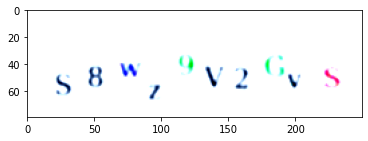

In [13]:
plt.imshow(img)

In [37]:
len(train_dataset[0]['targets'].numpy())

10

In [38]:
lbl_encoder.inverse_transform(train_dataset[0]['targets'].numpy())

ValueError: y contains previously unseen labels: [62]

Before passing the outputs of the maxpool layer into the custom RNN layer, you have to do certain things

-> permutation (batchsize, width, channels, height)


In [1]:
import torch
from torch import nn
from torch.nn import functional as F


class CaptchaModel(nn.Module):
    def __init__(self, num_chars=36):
        super(CaptchaModel, self).__init__()

        self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3, 3), padding=(1, 1))
        self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
        self.max_pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.linear_1 = nn.Linear(1024, 64)
        self.drop_1 = nn.Dropout(0.2)

        self.gru = nn.GRU(
            64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True
        )
        self.output = nn.Linear(64, num_chars + 1)

    def forward(self, images, targets=None):
        bs, ch, ht, wd = images.size()
        # print(bs, ch, ht, wd)
        x = F.relu(self.conv_1(images))
        # print(x.size())
        x = self.max_pool1(x)
        # print(x.size())

        x = F.relu(self.conv_2(x))
        # print(x.size())
        x = self.max_pool2(x)  # 1, 64, 18, 75
        # print(x.size())  # before passing these outputs into custom rnn permute the outputs (0, 3, 1, 2)
        x = x.permute(
            0, 3, 1, 2
        )  # 1, 75, 64, 18   # because we have to go through the width of the images
        # print("1st permute: ", x.size())
        x = x.view(bs, x.size(1), -1)
        # print(x.size())
        x = self.linear_1(x)
        x = self.drop_1(x)
        # print(x.size())
        x, _ = self.gru(x)
        # print(x.size())
        x = self.output(x)
        # print(x.size())
        # To calculate the ctc loss, we should again permute it
        # this you have to remember, timestamps, batches, values
        x = x.permute(1, 0, 2)
        # print(x.shape)

        if targets is not None:
            # ctc loss is already implemented in pytorch, but it is not straight forward.
            # it takes log softmax values.
            log_softmax_values = F.log_softmax(
                x, 2
            )  # (x, 2) indicates, x th second index which is num_chars + 1

            # Two things have to specified here, length of inputs and len of outputs
            input_lengths = torch.full(
                size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
            )
            # print(input_lengths)
            targets_lengths = torch.full(
                size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            )
            # print(targets_lengths)
            loss = nn.CTCLoss(blank=0)(
                log_softmax_values, targets, input_lengths, targets_lengths
            )

            return x, loss

        return x, None

model = CaptchaModel()


In [2]:
import albumentations
import torch
import torch.nn as nn
import numpy as np
from PIL import Image, ImageFile
from torch.utils.data import Dataset
image = Image.open("../input/raw_captcha/yelput#.png").convert("RGB")
aug = albumentations.Compose(
            [albumentations.Normalize(
                always_apply=True)
             ])
image = image.resize(
                (65, 300), resample=Image.BILINEAR
            )


image = np.array(image)
aug_image = aug(image=image)
image = aug_image["image"]
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float)


model.load_state_dict(torch.load("../input/captcha.pth", map_location=torch.device('cpu')))





<All keys matched successfully>

In [5]:
image = image.reshape(

TypeError: reshape(): argument 'shape' must be tuple of ints, but found element of type tuple at pos 2

In [55]:
model.eval()
output, _ = model(image)

ValueError: not enough values to unpack (expected 4, got 3)